# Imports

In [10]:
import sys, platform, os
from importlib import reload
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import healpy as hp
import camb
from camb import model, initialpower
import pymaster as nmt

import config
import utils as ut
from utils import alm_len_from_nsides
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print(f'Using healpy {hp.__version__} installed at {os.path.dirname(hp.__file__)}')
print(f'Using CAMB {camb.__version__} installed at {os.path.dirname(camb.__file__)}')
print(f'Using pymaster {nmt.__version__} installed at {os.path.dirname(nmt.__file__)}')
# make sure the version and path is what you expect

Using healpy 1.17.3 installed at /Users/blu3/miniforge3/envs/leakless/lib/python3.9/site-packages/healpy
Using CAMB 1.5.9 installed at /Users/blu3/miniforge3/envs/leakless/lib/python3.9/site-packages/camb
Using pymaster 2.3.3 installed at /Users/blu3/miniforge3/envs/leakless/lib/python3.9/site-packages/pymaster


In [11]:
reload(ut)

<module 'utils' from '/Users/blu3/PycharmProjects/leakless/utils/__init__.py'>

# Dataset Construction

In [12]:
#Set up a new set of parameters for CAMB
#The defaults give one massive neutrino and helium set using BBN consistency
params = {
    'H0':  (67.66, 0.42),
    'ombh2': (0.02242, 0.00014),
    'omch2': (0.11933, 0.00091),
    'tau': (0.0561, 0.0071),
    'As': (2.105e-09, 3.000e-11),
    'ns': (0.9665, 0.0038),
    'mnu': 0.06,
    'omk': 0,
    'halofit_version': 'mead',
    'lmax': 3000,
}

sampled = ut.sample_normal(params, best_fit=True)
sampled

{'H0': 67.66,
 'ombh2': 0.02242,
 'omch2': 0.11933,
 'tau': 0.0561,
 'As': 2.105e-09,
 'ns': 0.9665,
 'mnu': 0.06,
 'omk': 0,
 'halofit_version': 'mead',
 'lmax': 3000}

In [13]:
pars = camb.set_params(**sampled)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)
lensedCL = powers['lensed_scalar']

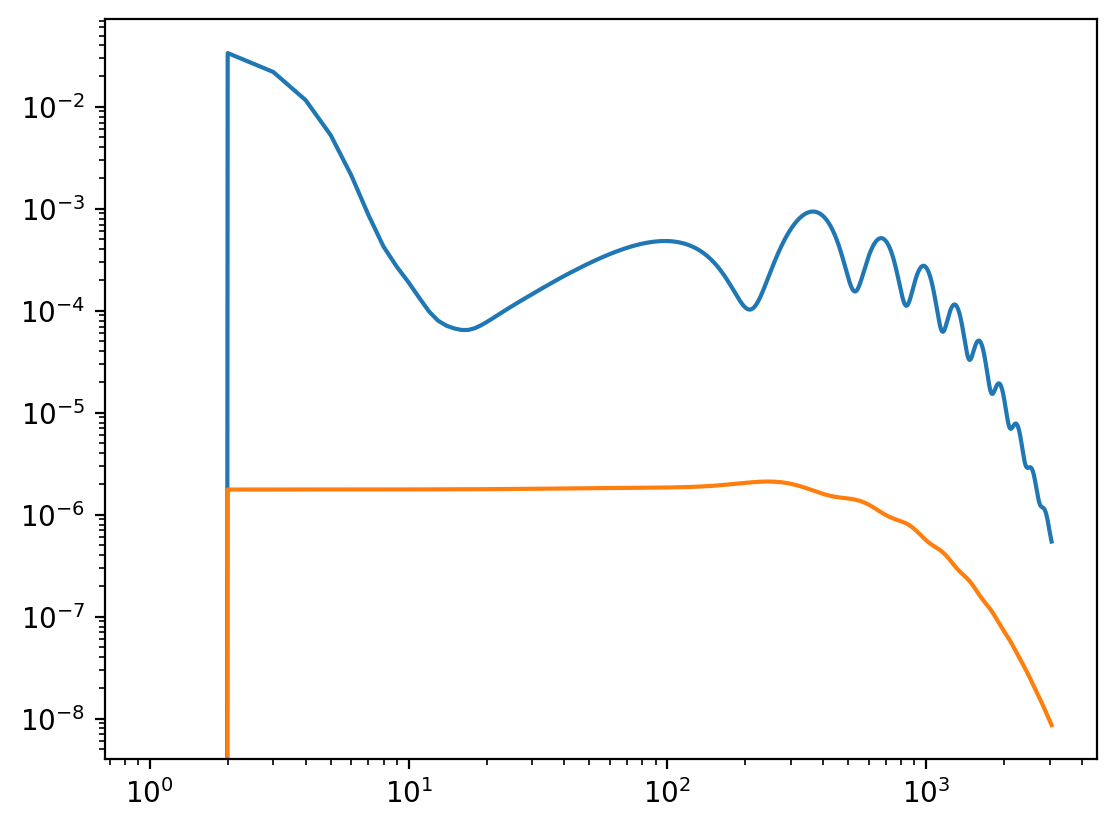

In [14]:
plt.loglog(lensedCL[:, 1:3])

In [15]:
nsides = 64
seed = config.SEED
np.random.seed(seed)

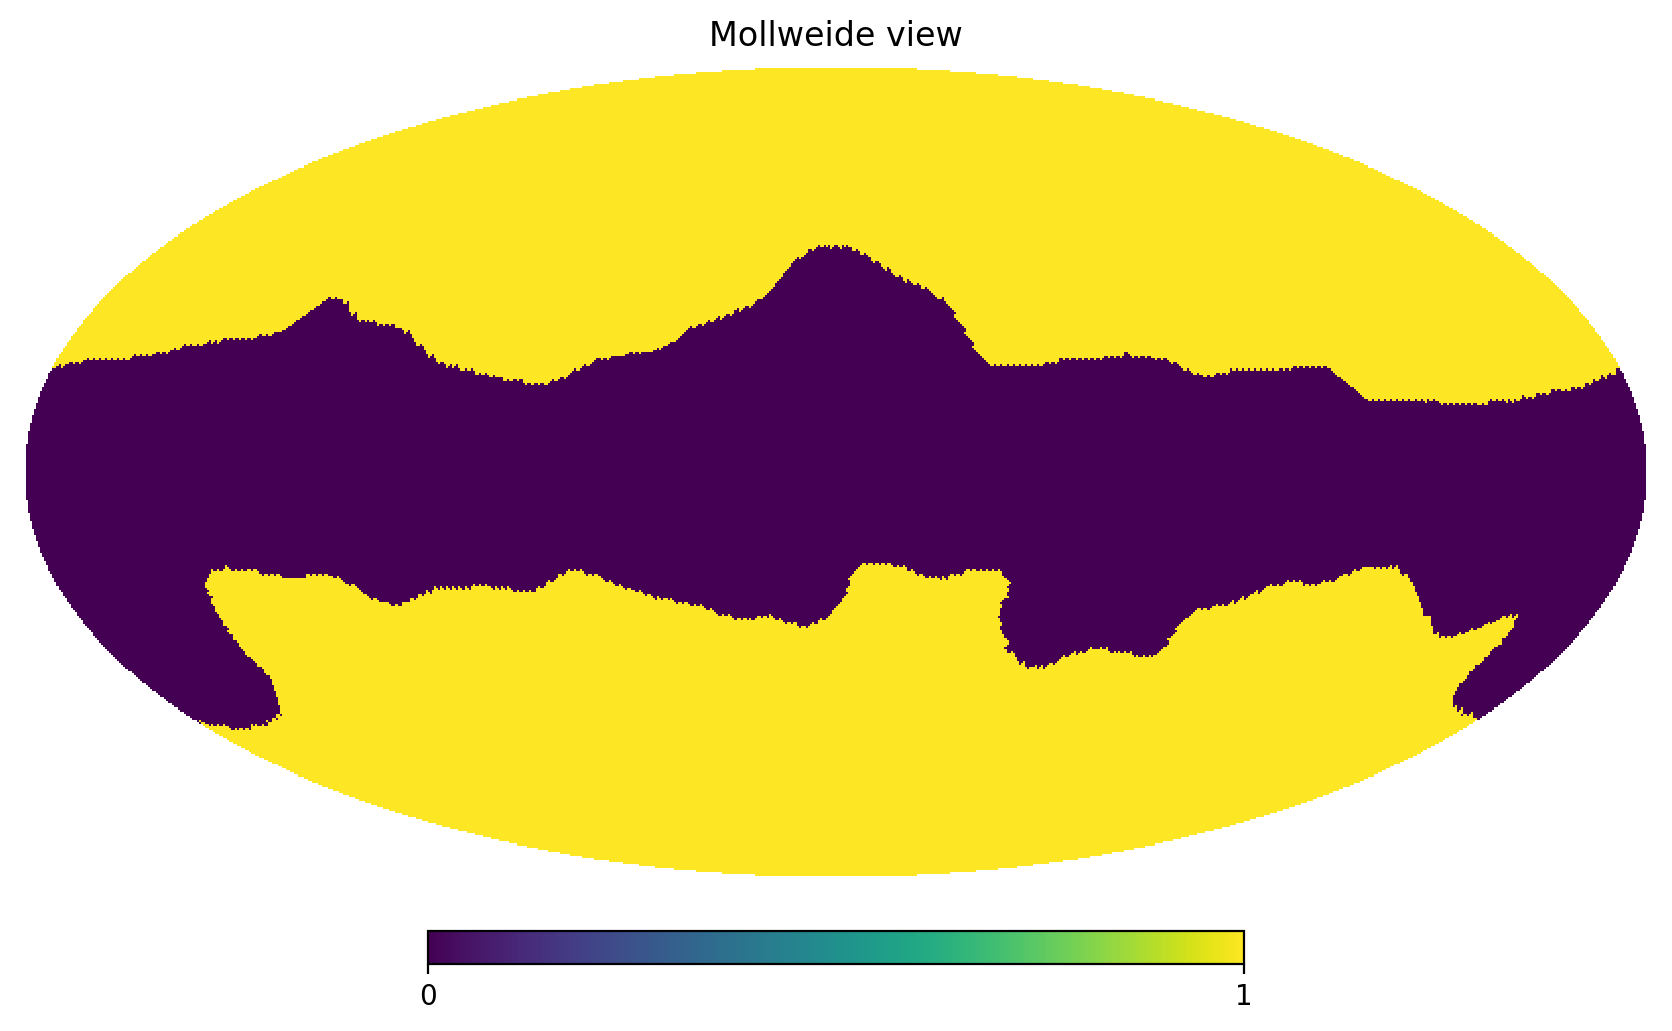

In [16]:
mask = hp.read_map("binary_GAL_mask_N1024.fits", field=1)
low_mask = hp.ud_grade(mask, nside_out=nsides, dtype=np.int32)
hp.mollview(low_mask)

In [17]:
tqu = hp.synfast(lensedCL.T, nside=nsides, new=True)
teb = hp.map2alm(tqu)

emode = teb[1]
emap = hp.alm2map(emode, nside=nsides)
bmode = teb[2]
bmap = hp.alm2map(bmode, nside=nsides)

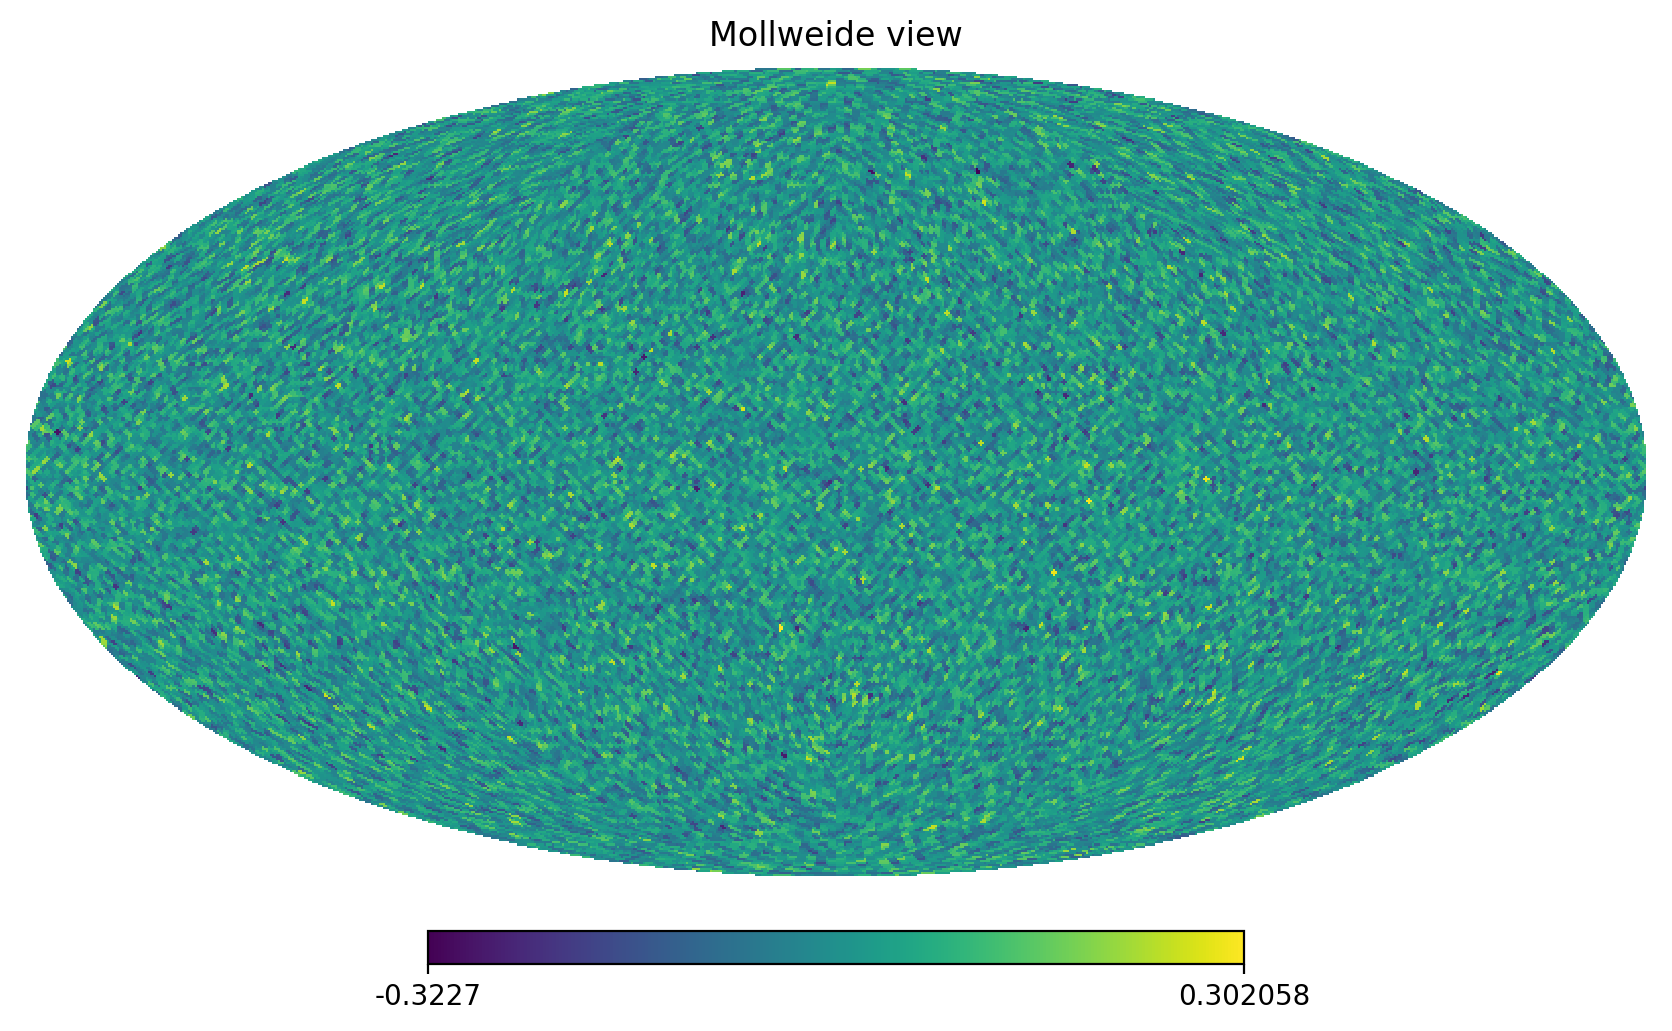

In [18]:
hp.mollview(bmap)

In [19]:
tqu_mask = tqu * low_mask
e_mask = emap * low_mask
b_mask = bmap * low_mask

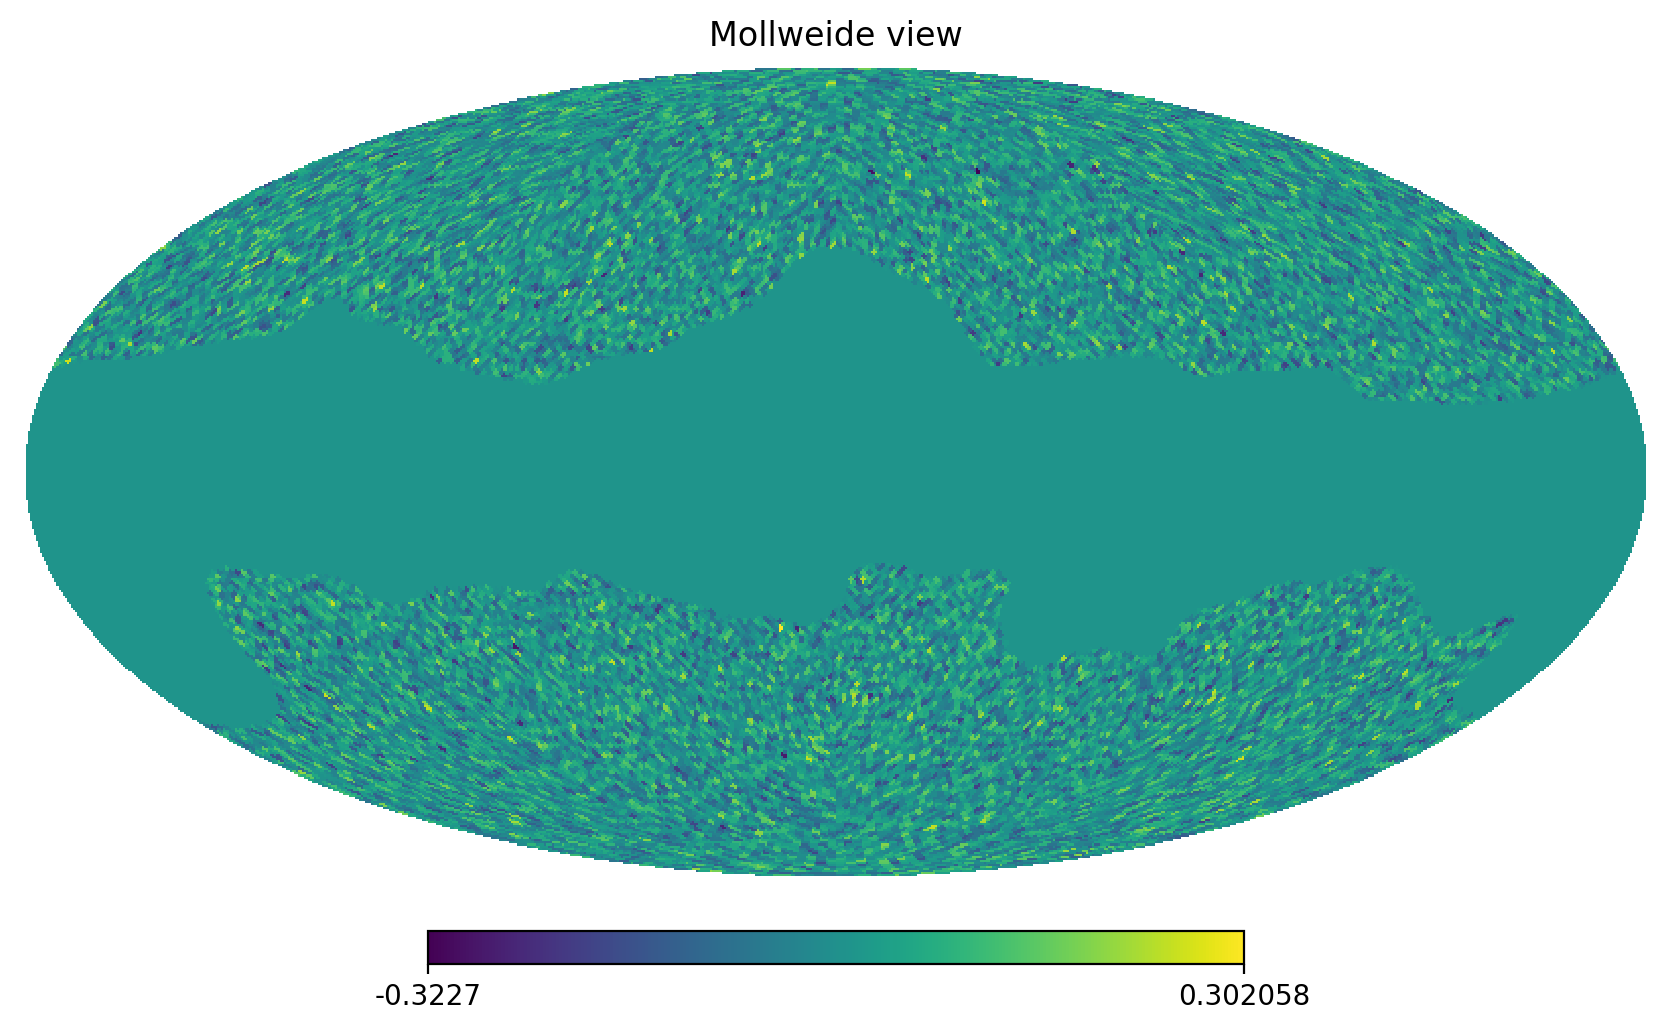

In [20]:
hp.mollview(b_mask)

In [21]:
alm_mask = hp.map2alm(tqu_mask)
e_alm = hp.map2alm(e_mask)
b_alm = hp.map2alm(b_mask)

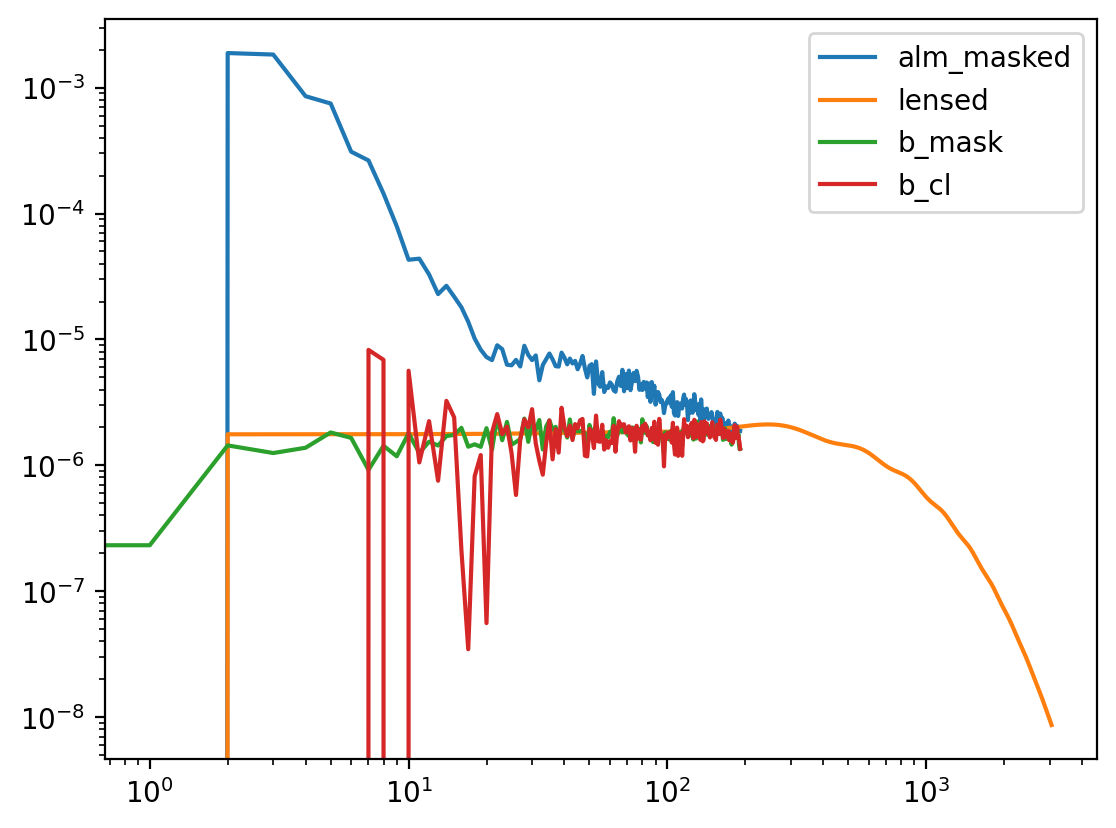

In [22]:
plt.loglog(hp.alm2cl(alm_mask[2]), label='alm_masked')
plt.loglog(lensedCL.T[2], label='lensed')
plt.loglog(hp.anafast(b_mask)/0.6, label='b_mask')
plt.loglog(hp.alm2cl(alm_mask[2], b_alm)/0.6, label='b_cl')
plt.legend()

In [23]:
np.mean(mask)

0.6004676024119059

# Dataset Validation

In [12]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [19]:
g = np.load('stacks.npy', mmap_mode='r')
g = g[0]
g.shape

(8, 18528)

In [22]:
a = g[2]
b = g[3]
b_comb = a + 1j*b

a = g[6]
b = g[7]
true = a + 1j*b

In [23]:
mask = hp.read_map("binary_GAL_mask_N1024.fits", field=1)
factor = np.mean(mask)

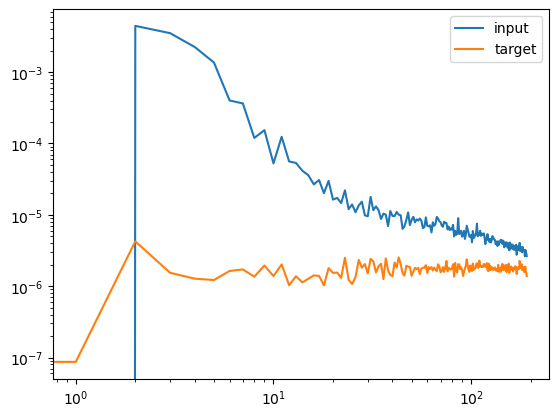

In [25]:
plt.loglog(hp.alm2cl(b_comb)/factor, label='input')
plt.loglog(hp.alm2cl(true)/factor, label='target')
plt.legend()

# Analysis

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from models import Leakless
from data_construction import leaklessDataModule
from utils.analysis import leak_test
from utils.harmonic_helpers import recombine

model = Leakless.load_from_checkpoint("checkpoints/unet_0.ckpt")
data_module = leaklessDataModule()

/Users/blu3/miniforge3/envs/leakless/lib/python3.9/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.1.post0, which is newer than your current Lightning version: v2.5.1


In [3]:
input_vector, output_vector, target_vector = leak_test(model, ntrials=40, mape=True)
input_vector.shape, output_vector.shape, target_vector.shape

############################################
#      BEGINNING RANDOM BATCH TESTING      #
############################################
#############################################
#      40 TRIALS, 10 BATCHES of 4 SIZE      #
#############################################
##################################################
#      TESTING COMPLETE, BEGINNING ANALYSIS      #
##################################################
#############################################
#      RANDOM INPUT TESTING TRIALS: 40      #
#############################################
##############################
#      MAE: 0.000632135      #
##############################
############################
#      MAPE: 6542.02%      #
############################


((40, 4, 18528), (40, 4, 18528), (40, 4, 18528))

In [4]:
test_input = input_vector.mean(axis=0)
test_output = output_vector.mean(axis=0)
test_target = target_vector.mean(axis=0)
test_input.shape, test_output.shape, test_target.shape      # should be (4, npoints)

((4, 18528), (4, 18528), (4, 18528))

In [5]:
idx = 3
if
test_input = input_vector[idx]
test_output = output_vector[idx]
test_target = target_vector[idx]
test_input.shape, test_output.shape, test_target.shape      # should be (4, npoints)

((4, 18528), (4, 18528), (4, 18528))

In [6]:
e_in, b_in = recombine(test_input)
e_out, b_out = recombine(test_output)
e_target, b_target = recombine(test_target)

b_in.shape, b_out.shape, b_target.shape     # should be (npoints, )

((18528,), (18528,), (18528,))

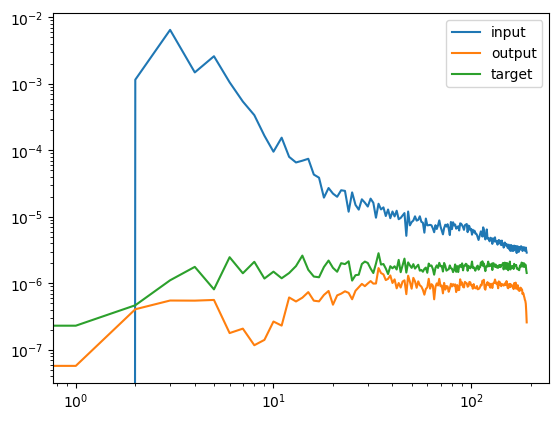

In [7]:
mask = hp.read_map("binary_GAL_mask_N1024.fits", field=1)
factor = np.mean(mask)

plt.loglog(hp.alm2cl(b_in)/factor, label='input')
plt.loglog(hp.alm2cl(b_out)/factor, label='output')
plt.loglog(hp.alm2cl(b_target)/factor, label='target')
plt.legend()

In [32]:
#TODO: Figure out performance issues
#TODO: Test new architectures